In [8]:
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.asl_dvs import ASLDVS
from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets.nav_gesture import NAVGestureWalk, NAVGestureSit
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets.n_mnist import NMNIST

import torch
import torchvision


In [2]:
# root_dir = './datasets/Imagenet'
# train_set = ESImageNet(root_dir, train=True, data_type='frame')
# test_set = ESImageNet(root_dir, train=False, data_type='frame')

In [2]:
CIFAR10DVS.get_H_W()

(128, 128)

In [3]:
# i = 1
# for name, link, id in ESImageNet.resource_url_md5():
#     if 10<i:
#         print('Getting the link: ', link)
#         r = requests.get(link, allow_redirects=True)
#         print('Download content at folder')
#         open('/home/shihao/ProjectDiego/code/datasets/Imagenet/download/'+name,'wb').write(r.content)
#         print('Done', name)
#     i+=1

In [9]:
root_dir = '/home/shihao/ProjectDiego/code/datasets/DVSGesture'
train_set_events = DVS128Gesture(root_dir, train=True, data_type = 'event')

In [10]:
event, label = train_set_events[0]

for k in event.keys():
    print(k, event[k])

print('label', label)

t [80048267 80048277 80048278 ... 85092406 85092538 85092700]
x [49 55 55 ... 60 85 45]
y [82 92 92 ... 96 86 90]
p [1 0 0 ... 1 0 0]
label 0


## Get frames data


In [11]:
train_set_frames = DVS128Gesture(root_dir, train=True, data_type='frame',frames_number=20, split_by='number')


The directory [/home/shihao/ProjectDiego/code/datasets/DVSGesture/frames_number_20_split_by_number] already exists.


In [17]:
x, label = train_set_frames[0]
print(type(x))

<class 'numpy.ndarray'>


In [19]:
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

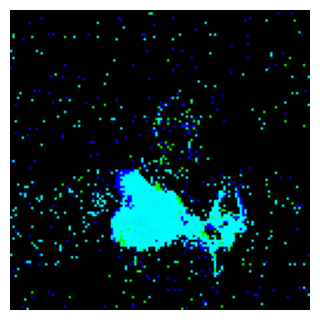

In [33]:
if isinstance(x, np.ndarray):
    x = torch.from_numpy(x)
to_img = transforms.ToPILImage()
img_tensor = torch.zeros([x.shape[0], 3, x.shape[2], x.shape[3]])
img_tensor[:, 1] = x[:, 0]
img_tensor[:, 2] = x[:, 1]

img_list = []
for t in range(img_tensor.shape[0]):
    img_list.append(to_img(img_tensor[t]))

fig = plt.figure(frameon=False)
fig.set_size_inches(3,3)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(img_list[7], aspect='auto')
fig.savefig("./../images/event7.svg", dpi=300)

plt.show()


## Fixed Duration Integrating


In [6]:
import torch
from torch.utils.data import DataLoader
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask, dvs128_gesture

In [8]:
root_dir = '/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture'
train_set_frames = dvs128_gesture.DVS128Gesture(root_dir, data_type='frame', duration=1000000, train=True)

Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/4].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/0].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/5].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/9].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/1].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/2].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_1000000/test/10].
Mkdir [/home/shihao/ProjectDiego/tutorials/spikingJelly/datasets/DVSGesture/duration_10000

In [9]:
for i in range(5):
    x, y = train_set_frames[i]
    print(f'x[{i}].shape=[T, C, H, W]={x.shape}')

x[0].shape=[T, C, H, W]=(6, 2, 128, 128)
x[1].shape=[T, C, H, W]=(6, 2, 128, 128)
x[2].shape=[T, C, H, W]=(5, 2, 128, 128)
x[3].shape=[T, C, H, W]=(5, 2, 128, 128)
x[4].shape=[T, C, H, W]=(7, 2, 128, 128)


In [10]:
train_data_loader = DataLoader(train_set_frames, collate_fn = pad_sequence_collate, batch_size=5)

In [13]:
for x, y, x_len in train_data_loader:
    print(f'x.shape=[N, T, C, H, W]={tuple(x.shape)}')
    print(f'x_len={x_len}')
    mask = padded_sequence_mask(x_len) 
    print(f'mask=\n{mask.t().int()}')
    break

x.shape=[N, T, C, H, W]=(5, 7, 2, 128, 128)
x_len=tensor([6, 6, 5, 5, 7])
mask=
tensor([[1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)


## Custom Integrating Method

In [16]:
import spikingjelly.datasets as sjds
import numpy as np

In [19]:
def integrate_events_to_2_frames_randomly(events: dict, H: int, W:int):

    index_split = np.random.randint(low=0, high=events['t'].__len__())
    frames = np.zeros([2,2,H,W])
    t, x, y, p = (events[key] for key in ('t', 'x', 'y', 'p'))
    frames[0] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, 0, index_split)
    frames[1] = sjds.integrate_events_segment_to_frame(x, y, p, H, W, index_split, events['t'].__len__())
    
    return frames

In [ ]:
train_set_randomly = DVS128Gesture(root_dir, train=True, data_type='frame', custom_integrate_function=integrate_events_to_2_frames_randomly)


In [ ]:
from spikingjelly.datasets import play_frame
import matplotlib.pyplot as plt
frame, label = train_set_randomly[500]
play_frame(frame)
plt.show()